## ZTF alerts demo

In this demo, we will:
- Set up `Docker`
- Using `Docker`, deploy a `MongoDB` database, fetch a night worth of (pre-filtered to reduce size) public ZTF alerts, ingest it into the database, and create indices in the database for faster queries
- Set up `Robo3T` and use it to look at the database and query it
- Query the database using `python`
- Inspect the contents of an alert packet
- Construct and plot a light curve
- Plot the cutout images from an alert packet


### Download and install `Docker` and `Robo3T`
- Download and install the appropriate version of `Docker` for your platform from [here](https://www.docker.com/community-edition). You will need to create an account on their website.
- Download and install `Robo3T` from [here](https://robomongo.org/download).
  We will use it to connect to the database.

### Fetch, build, and run the code to deploy a `MongoDB` database, fetch a night worth of (pre-filtered to reduce size) public ZTF alerts, ingest it into the database, and create indices in the database for faster queries

This is a lot of stuff! Sounds scary, however with the help of `Docker`, we will only have to run a few simple commands to do all that.

Clone the repo and `cd` into the directory:

```bash
git clone https://github.com/dmitryduev/ztf-alerts-demo.git
cd ztf-alerts-demo
```

The inside/contents of a `Docker` container get destroyed when it is removed, so we need to tell `Docker` to keep the useful data in a "persistent" storage.

Create a so-called persistent `Docker` volume for `MongoDB`:
```bash
docker volume create alert-fetcher-mongo-volume
```

Launch the `MongoDB` container. (Feel free to change u/p for the db admin)
```bash
docker run -d --restart always --name alert-fetcher-mongo -p 27018:27017 \
       -v alert-fetcher-mongo-volume:/data/db \
       -e MONGO_INITDB_ROOT_USERNAME=mongoadmin \
       -e MONGO_INITDB_ROOT_PASSWORD=mongoadminsecret \
       mongo:latest
```

That's it for the database set-up! You can now connect to it on `localhost` on port `27018`.

Finally, build and launch the alert-fetcher container. We will bind-mount a directory on your host machine to store the alerts:
```bash
cd alert-fetcher
docker build -t alert-fetcher -f Dockerfile .
# make sure path ./alerts (or whatever path you specify) exists
docker run --rm -v ./alerts:/alerts \
           --name alert-fetcher -d --link alert-fetcher-mongo:mongo -it alert-fetcher
```

This will launch a program that will fetch a pre-filtered (demo) set of public ZTF alerts from July 13, 2018, ingest that into the MongoDB database, and create indicies to accelerate queries. The script will add a `coordinates` field to each that is not part of the original alert packets, to allow 2d indexation on the sphere for fast positional/cone searches. Additionally, a unique string `candid_objectId` is used a the alert identifier in the database.

---
We can now use `Robo3T` to connect to the database and take a look at the alerts. Launch `Robo3T` and click "create" connection. 
- Name the connection, for example, `local_docker_alerts_demo`
- Use `localhost` : `27018` as the address
- On the `Authentication` tab, check "perform authentication", and use `admin` for `Database`, `mongoadmin` for `User Name`, `mongoadminsecret` for 'Password'(if you did not choose other u/p), and `SCRAM-SHA-1` for `Auth Mechanism`
- Click `Save` and then `Connect`

`Robo3T` will connect to the database. To see the ingested alerts, click `ztf_alerts` -> `Collections` -> `alerts`.

---
##### Notes [optional]

To check the running/stopped containers, type:
```bash
docker ps -a
```

To stop and remove a container, run:
```bash
docker stop container_name
docker rm -f container_name
```

To get all public alerts from the ZTF archive for a given night, remove `--demo` from the last line of the file `alert-fetcher/Dockerfile` and change the date string. Then re-build and re-run the alert-fetcher container.

Every time when you change the code that is used inside a container, the latter must be re-build and restarted.

Alerts are stored in the database in a serialized binary format that resembles the Apache Avro format used in the packets in that it can be easily converted into `json` or a `python` dictionary.

---

We will now explore the contents of an avro packet. We will also learn how to construct and display a light curve for an alert and plot the cutout images.

_NOTE:_ You may want to look at Erik Bellm's Jupyter notebook with some more examples.

In [1]:
import os
import io
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import fastavro

from astropy.time import Time
from astropy.io import fits
import aplpy

%matplotlib inline

/Users/dmitryduev/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Let's look at a particular avro packet:

In [3]:
avro_packet = './alerts/20180713/558359715915010021.avro'
with open(avro_packet, 'rb') as fa:
    freader = fastavro.reader(fa)
    schema = freader.schema

    for packet in freader:
        print(packet.keys())

dict_keys(['objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])


The schema is stored in the packet:

In [ ]:
schema

The payload, once in memory, is a python dictionary, so the attributes are easy to access

In [ ]:
packet

In [4]:
print('JD: {} Filter: {} Mag: {:.2f}+/-{:.2f}'.format(
    packet['candidate']['jd'], packet['candidate']['fid'],
    packet['candidate']['magpsf'], packet['candidate']['sigmapsf']))

JD: 2458312.8597106 Filter: 1 Mag: 18.83+/-0.09


**NOTE ESPECIALLY:** the magnitudes here do not include the magnitude of the underlying reference source (if present), so if this is a variable star further adjustment is needed.

Record access like this is a little verbose; let's wrap things up in a pandas dataframe for ease of access (and faster loading).

Now let's extract the lightcurves. The alert packet formats are nested, so the historical detections (if present) have the same structure as the candidate triggering the alert (minus a couple fields).

In [5]:
def make_dataframe(packet):
    df = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    return pd.concat([df, df_prv], ignore_index=True)

In [6]:
dflc = make_dataframe(packet)
dflc

,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,dec,decnr,...,ssmagnr,ssnamenr,sumrat,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos
0,0.834,0.334940,0.744,0.298795,5.583597e+17,1.012,5.921492,0.990,28.690015,28.690045,...,-999,null,0.991501,11.616,15.9605,-999.0,21.0,0.0,804.370728,1235.827026
1,0.785,0.406736,0.771,0.399482,5.283940e+17,1.012,5.872590,0.977,28.689995,28.690045,...,None,None,1.000000,NaN,NaN,NaN,87.0,NaN,801.806030,1337.579956
2,0.765,0.317427,0.727,0.301660,5.294034e+17,1.012,3.644890,0.984,28.690009,28.690045,...,None,None,0.979505,NaN,NaN,NaN,209.0,NaN,807.197998,1258.339966
3,0.878,0.295623,0.840,0.282828,5.324025e+17,1.012,2.086550,0.979,28.690028,28.690045,...,None,None,1.000000,NaN,NaN,NaN,15.0,NaN,803.140991,1246.989990
4,0.974,0.332423,0.907,0.309556,5.343982e+17,1.012,2.140210,0.978,28.689969,28.690045,...,None,None,1.000000,NaN,NaN,NaN,31.0,NaN,803.898987,1340.150024
5,1.189,0.379872,1.100,0.351438,5.353941e+17,1.012,1.746510,0.971,28.689968,28.690045,...,None,None,1.000000,NaN,NaN,NaN,50.0,NaN,802.281982,1137.810059
6,0.734,0.329148,0.716,0.321076,5.374373e+17,1.012,7.425900,1.000,28.690023,28.690045,...,None,None,1.000000,NaN,NaN,NaN,363.0,NaN,808.231018,1156.479980
7,0.769,0.351142,0.719,0.328311,5.384377e+17,1.012,4.711660,0.985,28.690003,28.690045,...,None,None,0.996816,NaN,NaN,NaN,129.0,NaN,809.143005,1159.790039
8,0.779,0.340175,0.753,0.328821,5.394212e+17,1.012,3.211380,1.000,28.690004,28.690045,...,None,None,1.000000,NaN,NaN,NaN,19.0,NaN,811.268982,1179.329956
9,0.677,0.354450,0.624,0.326702,5.404465e+17,1.012,5.214570,0.981,28.690020,28.690045,...,None,None,0.977343,NaN,NaN,NaN,27.0,NaN,809.742004,1202.829956


We see that some of the historical detections are upper limits, signified by the NaNs. Note that the most recent candidate has a few fields that are not present for the prv_candidates.

Let's plot it!

In [8]:
def plot_lightcurve(dflc, days_ago=True):
    
    filter_color = {1: 'green', 2: 'red', 3: 'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.sum(w):
            plt.errorbar(t[w], dflc.loc[w, 'magpsf'], dflc.loc[w, 'sigmapsf'],
                         fmt='.', color=color)
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet], dflc.loc[wnodet, 'diffmaglim'], 
                        marker='v', color=color, alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')

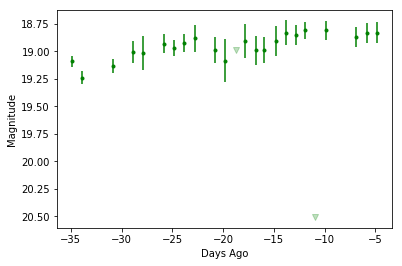

In [9]:
plot_lightcurve(dflc)

Now let's figure out how to display the cutout images. Note that these are gzip-compressed fits files stored as bytes.

In [10]:
def plot_cutout(stamp, fig=None, subplot=None, **kwargs):
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            if fig is None:
                fig = plt.figure(figsize=(4, 4))
            if subplot is None:
                subplot = (1, 1, 1)
            ffig = aplpy.FITSFigure(hdul[0], figure=fig, subplot=subplot, **kwargs)
            ffig.show_grayscale(stretch='arcsinh')
    return ffig


def show_stamps(packet):
    fig = plt.figure(figsize=(12, 4))
    for i, cutout in enumerate(['Science', 'Template', 'Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot=(1, 3, i+1))
        ffig.set_title(cutout)

INFO: Auto-setting vmin to  9.311e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.263e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.017e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.891e+02 [aplpy.core]


INFO: Auto-setting vmin to -4.302e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.761e+01 [aplpy.core]


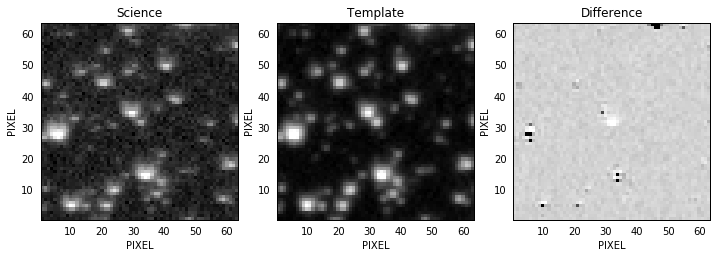

In [11]:
show_stamps(packet)